## The main point of the project
We receive data on the quantity of stored goods in the marketplace warehouses and coefficients (these files are stored by day in "used" -> "remains" and "coeff", respectively), which calculate the cost of storage for each specific day and week. A basic analysis of the results obtained is also carried out in the form of several graphs.

## Description of the input data
*coeff data*<br>
* **Склад** - storage location<br>
* **Логистика и хранение, %** - percentage of storage prices and logistics<br>
* **Логистика за 3л** - price for logistics of goods with a volume of <=3 liters <br>
* **доп. л** - price for logistics of goods with a volume of > 3 liters (surcharge)<br>
* **Хранение за 3л** - price for storage of goods with a volume of <=3 liters<br>
* **доп. л (2)** - price for storage of goods with a volume of > 3 liters<br>

*remains data*<br>
* **Бренд** - The brand name associated with the product <br>
* **Предмет** - Describes the type or category of the product <br> 
* **Артикул продавца** - A unique identifier assigned by the seller to the product <br>
* **Артикул WB** - The SKU (Stock Keeping Unit) assigned by the Wildberries platform for the product <br>
* **Объем, л** - Specifies the volume of the product, measured in liters <br>
* **Баркод** - A unique machine-readable code that provides information about the product <br>
* **Размер вещи** -  Indicates the size of the item, applicable for items like clothing or accessories <br>
* **В пути до клиента** -  Quantity of the product currently in transit to the customer <br>
* **В пути от клиента** -  Quantity of the product currently in transit back from the customer <br>
* **Итого по складам** -  The total quantity of the product across all warehouse locations <br>
* **Коледино, Подольск, Казань, Электросталь, etc.** -  The quantity of the product available at each specific warehouse location <br>

## Objectives:
* **Count storage costs** - create table with result for each day
* **Create graphics with basic analysis of storage costs** - create and load graphics describing storage costs
* **Create pivot table for week** - create table with result for week in convinient form

## 0.1 Import modules

In [6]:
import os
import datetime
import sqlite3
import warnings
import locale

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## 0.2 Set parameters

In [7]:
warnings.filterwarnings("ignore", category=UserWarning)
locale.setlocale(
    category=locale.LC_ALL,
    locale="Russian" 
)

'Russian_Russia.1251'

## 1.1 Read coeff files and basic preprocessing for them

In [8]:
def read_coef(excpt) -> dict:
    #load files in dict with date as key, using param decimal=','
    coeff = {datetime.datetime.strptime(filename[-15:-5], '%Y-%m-%d').date(): pd.read_excel(f'used/coeff/{filename}', decimal=',') for filename in os.listdir('used/coeff')}
    for date in coeff:
        #delete useless row, which may interfere with 
        coeff[date] = coeff[date][coeff[date]['Склад'] != 'Маркетплейс']
        #change types of cols 
        coeff[date] = coeff[date].astype({'Хранение за 3л': float, 'доп. л.1':float})

        #change names for warehouses to desired format
        cities = change_names(coeff[date], excpt)
        #flip table and set new cols 
        coeff[date] = coeff[date].T
        coeff[date].columns = cities

    return coeff

In [9]:
def change_names(coeff, excpt):
    '''
    Change names for warehouses to desired format
    '''
    #read names of required col
    names = list(coeff['Склад'])
    for i in range(len(names)):
        #skip exceptions
        if names[i] in excpt:
            continue
        #remove excess
        names[i] = names[i].split()[0]
    return names

## 1.2 Read remains files and basic preprocessing for them

In [10]:
def read_remains():
    return {datetime.datetime.strptime('_'.join(filename.split('_')[1:])[:-5]+f'_{datetime.datetime.now().year}', '%B_%d_%Y').date(): pd.read_excel(f'used/remains/{filename}') for filename in os.listdir('used/remains')}

In [11]:
def update_remains(remains):
    #foll na values and create new col with summary value
    remains.fillna(0, inplace=True)
    remains['Итого в рублях'] = 0
    
    return remains

## 2 Count storage costs for each day

In [12]:
def calculate_expenses(remains, coeff):
    '''
    Calculate price for every product in every warehouse for current day
    '''
    #iterate through warehouses
    for city in list(remains.columns[10:-1]):
        #add value for all goods (because all goods, even its > 3 liters, include the price for 3 liters)
        remains[city] *= coeff[city]['Хранение за 3л']
        #add value for goods, which > 3 liters, for each liter
        remains.loc[(remains['Объем, л'] > 3) & (remains[city] > 0), city] += (coeff[city]['доп. л.1'] * (remains['Объем, л'] - 3))

        #add current warehouse value to summary value
        remains['Итого в рублях'] += remains[city]
    return remains

In [13]:
def download_result(main_table, date):
    '''
    Save result to a folder with the desired date
    '''
    main_table.to_excel(f'created\\{date.strftime("%d_%m_%Y")}.xlsx')

## 3 Create weekly pivot table

In [14]:
def load_to_db(table, tablename):
    '''
    Save weekly pivot table to db 
    '''
    conn = sqlite3.connect('storage.db')
    table.to_sql(tablename, conn, if_exists='replace', index=False)
    conn.close()

In [15]:
def create_weekly_sum(remains):
    '''
    Create weekly pivot table according to the pattern of each day
    '''
    #define cols by which the values will be grouped
    df_week = list(remains.values())
    gr_b = list(df_week[0].iloc[:, :7].columns)
    #concat dfs for week (day 1, day 2, day 3... -> week)
    weekly_sum = pd.concat(df_week).groupby(gr_b).sum(numeric_only=True).reset_index()

    #add a line with summary values by each cols
    weekly_sum.loc['Итого'] = weekly_sum.sum(axis=0, numeric_only=True)

    #set name for future file with date of given files
    filename = f'weekly_sum_{min(remains.keys()).strftime("%d_%m_%Y")}-{max(remains.keys()).strftime("%d_%m_%Y")}'

    #load df to db
    load_to_db(weekly_sum, filename)
    return weekly_sum

## 4 Create graphs

In [16]:
def create_sum_table(remains):
    '''
    Create weekle table with summary values of each warehouse 
    '''
    dfs = []
    for date in remains:
        #take the last row and all warehouses and turn it over
        res_df = remains[date].iloc[-1, 10:].to_frame().T
        #set index as date
        res_df.index = [date]
        dfs.append(res_df)
    #return df with concatenation and without na values
    return pd.concat(dfs).dropna(axis=1)

In [17]:
def create_curr_barplot(sum_table, city):
    '''
    Create barplot for each city by each day to track trends and outliers
    '''
    fig, ax = plt.subplots()

    #create a color palette that sets the color depending on the value
    norm = plt.Normalize(sum_table[city].min(), sum_table[city].max())
    colors_mapped = sns.color_palette("rocket_r", n_colors=len(sum_table)).as_hex()
    colors_mapped = [colors_mapped[int(norm(value) * (len(colors_mapped) - 1))] for value in sum_table[city]]

    sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)

    #set labels and labelsizes
    ax.set_xlabel("Дата")
    ax.set_ylabel("Сумма в рублях")
    ax.set_title(f"Сумма за хранение {city}")

    ax.tick_params(axis='x', labelsize=8)

    #save graph
    plt.savefig(f'graphics/cities/{city}.png')
    plt.show()

In [18]:
def graph_showing_relation(weekly_sum, param):
    '''
    Create graph (regplot) showing the dependence of storage costs on different values
    '''
    #delete summary values (outlier)
    weekly_sum = weekly_sum.iloc[:-1, :]    

    #delete zero-values, which don't allow you to display a full-fledged dependency
    weekly_sum = weekly_sum[weekly_sum[param] > 0]
    #filter data by standardization
    mean_value = weekly_sum[param].mean()
    std_dev = weekly_sum[param].std()
    filtered_data = weekly_sum[abs(weekly_sum[param] - mean_value) < 2 * std_dev]

    #set styles, colors and sizes
    sns.set_style("whitegrid") 
    sns.set_palette("mako")
    plt.figure(figsize=(10, 6))
    sns.regplot(y=filtered_data[param], x=filtered_data['Итого в рублях'], scatter_kws={'alpha':0.5})

    #save graph
    plt.savefig(f'graphics/relation/{param}.png')
    plt.show()

In [19]:
def create_graphs(remains, weekly_sum):
    '''
    Create all possible graphs with desired parametrs
    '''
    #create graphs with showing relation price-param
    params_relation = ['В пути до клиента', 'В пути от клиента', 'Объем, л', 'Итого по складам'] 
    for param in params_relation:
        graph_showing_relation(weekly_sum, param)

    #create barplot for each warehouse
    sum_table = create_sum_table(remains)
    for city in list(sum_table.columns):
        create_curr_barplot(sum_table, city)


In [20]:
def create_remains_on_tariff(excpt_city_names=[]):
    '''
    A function that combines and manages all the others
    '''
    #load files
    remains, coeff = read_remains(), read_coef(excpt_city_names)
    #iterate through dates
    for date in coeff:
        #check existence of remains by current date (else raise warning)
        if date not in remains:
            warnings.warn("Закройте используемые файлы", DeprecationWarning)
            continue

        #some preprocess data
        remains[date], coeff[date] = update_remains(remains[date]), coeff[date].to_dict()

        #count price for storage
        remains[date] = calculate_expenses(remains[date], coeff[date])
        #add row with summary values
        remains[date].loc['Итого'] = remains[date].sum(axis=0, numeric_only=True)
        #sort values
        remains[date].sort_values(by=['Бренд', 'Предмет', 'Артикул продавца'], inplace=True)

        #check if the files are open (else raise warning)
        try:
            download_result(remains[date], date)
        except PermissionError:
            warnings.warn("Закройте используемые файлы", DeprecationWarning)

    weekly_sum = create_weekly_sum(remains)
    create_graphs(remains, weekly_sum)

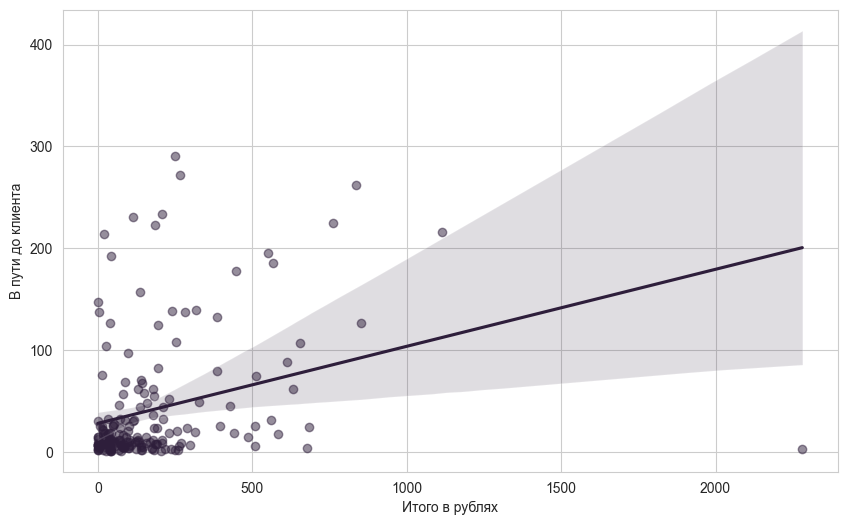

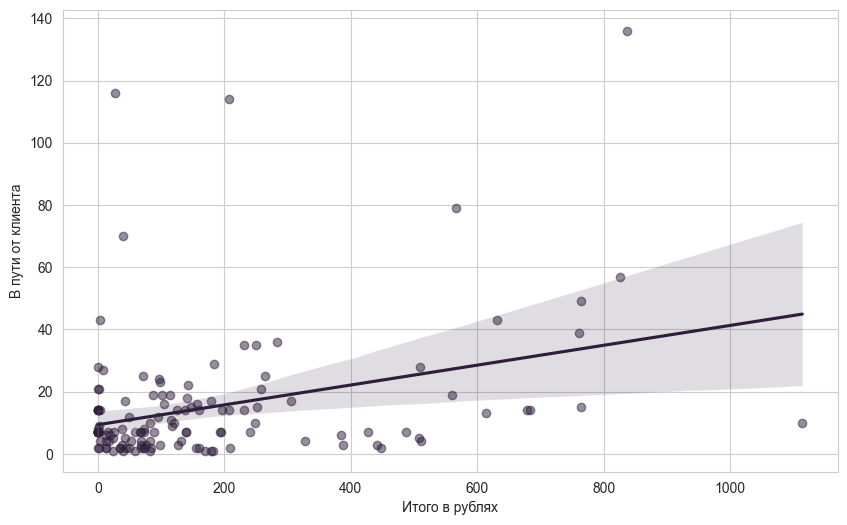

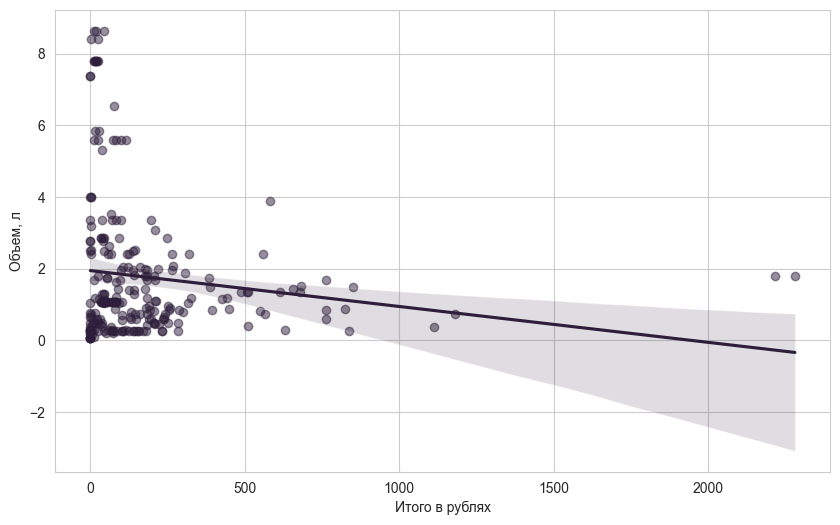

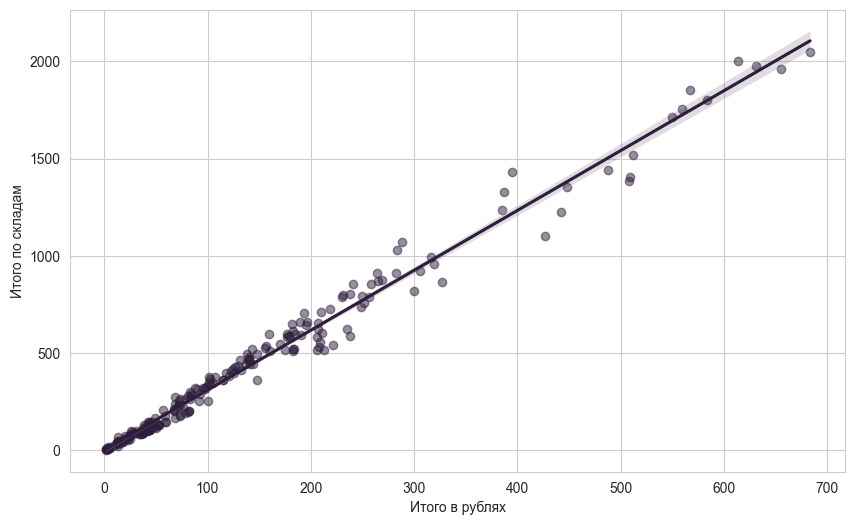

C:\Users\Kirill\AppData\Local\Temp\ipykernel_25924\1456861747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


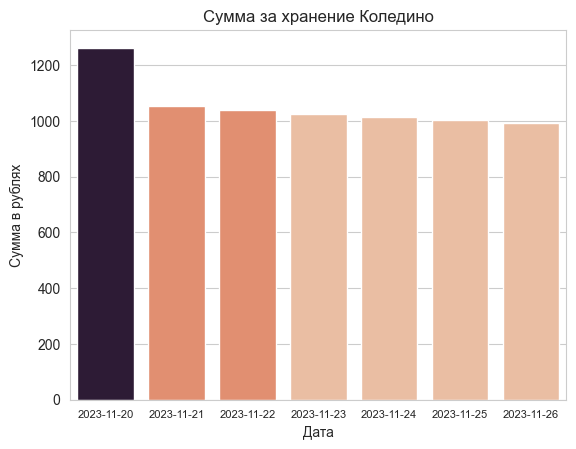

C:\Users\Kirill\AppData\Local\Temp\ipykernel_25924\1456861747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


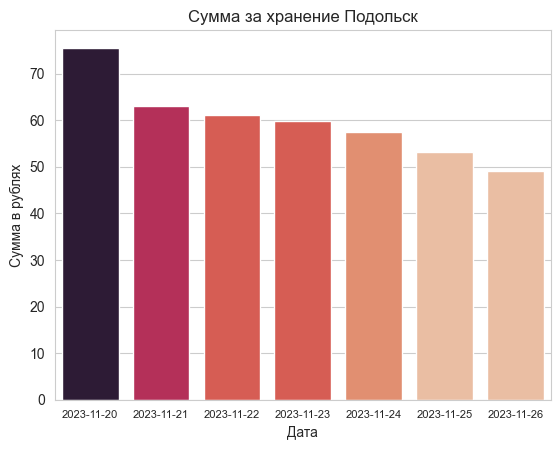

C:\Users\Kirill\AppData\Local\Temp\ipykernel_25924\1456861747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


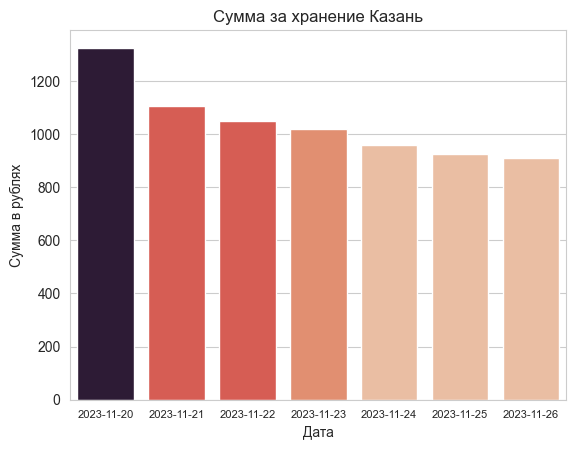

C:\Users\Kirill\AppData\Local\Temp\ipykernel_25924\1456861747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


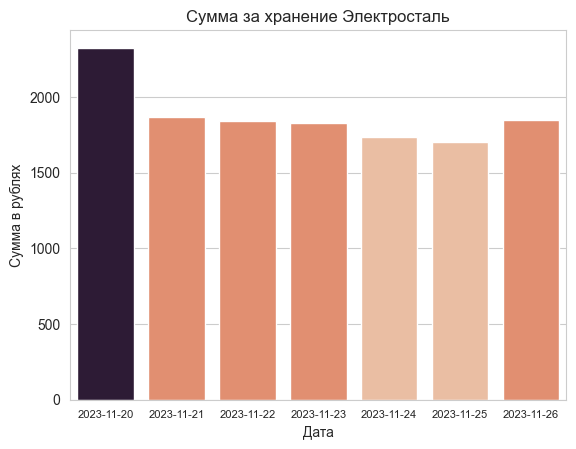

C:\Users\Kirill\AppData\Local\Temp\ipykernel_25924\1456861747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


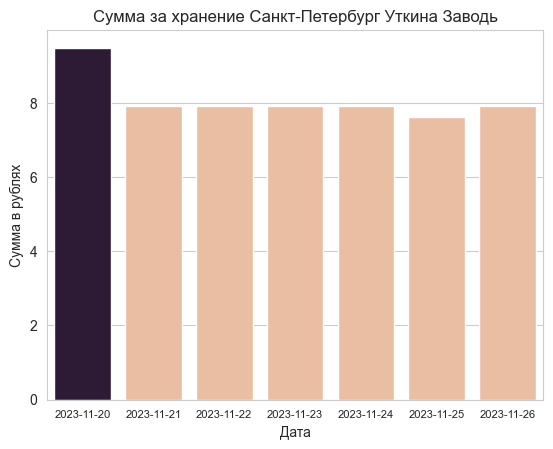

C:\Users\Kirill\AppData\Local\Temp\ipykernel_25924\1456861747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


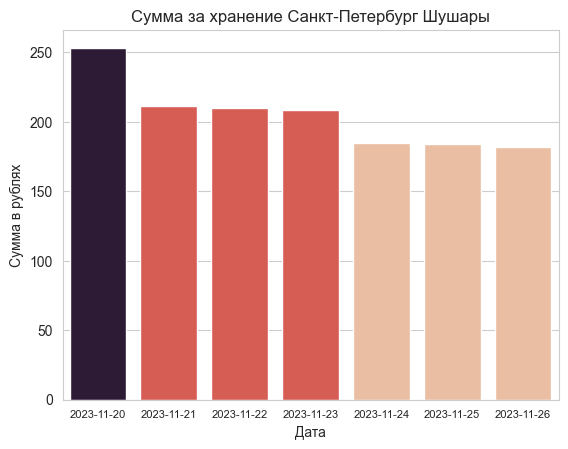

C:\Users\Kirill\AppData\Local\Temp\ipykernel_25924\1456861747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


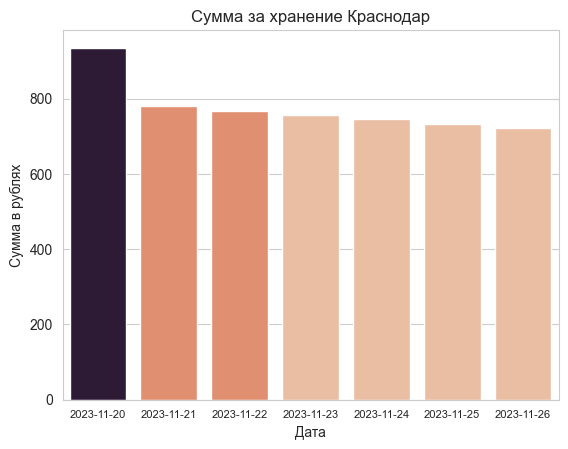

C:\Users\Kirill\AppData\Local\Temp\ipykernel_25924\1456861747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


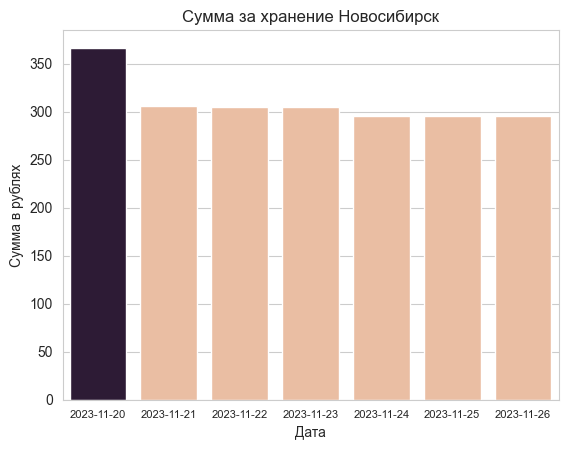

C:\Users\Kirill\AppData\Local\Temp\ipykernel_25924\1456861747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


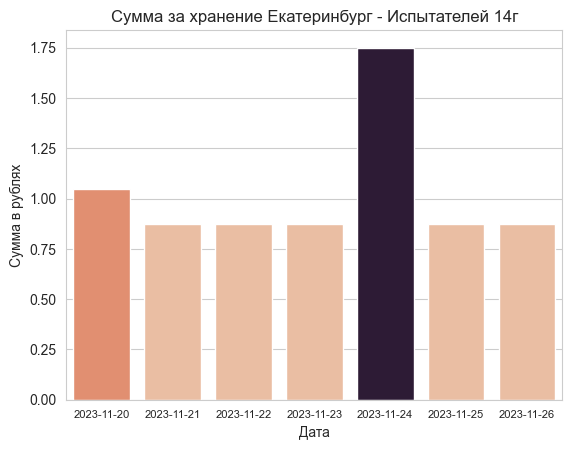

C:\Users\Kirill\AppData\Local\Temp\ipykernel_25924\1456861747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


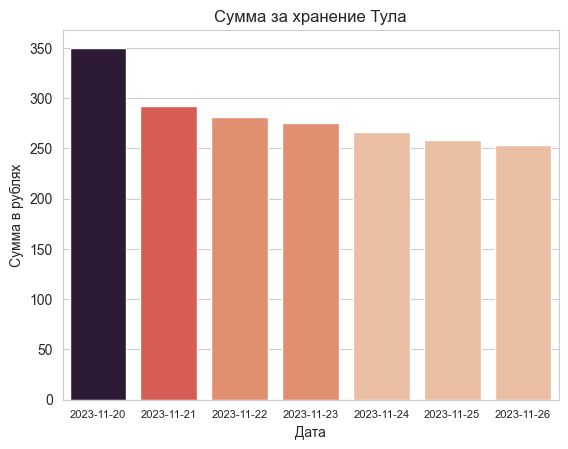

C:\Users\Kirill\AppData\Local\Temp\ipykernel_25924\1456861747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


In [ ]:
excpt_cities = ['Чехов 2', 'Екатеринбург - Испытателей 14г', 'Санкт-Петербург Шушары', 'Санкт-Петербург Уткина Заводь', 'Радумля СГТ', 'Белые Столбы', 'Белая дача']
create_remains_on_tariff(excpt_city_names=excpt_cities)